In [1]:
# import standard modules
import os 
import random

# import third party modules
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from pathlib import Path
from tensorflow.keras import Model
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras import optimizers
from tensorflow.keras import applications
from tensorflow.keras.applications import resnet
tf.executing_eagerly()

True

# Load the dataset
For this demo purpose the dataset is **limited to 10 samples**. However, the images are sampled from the provided data set by "einsen und nullen". For a better result of the network the data set needs to be increased with samples of similar images. However, the dataset used for training consists of two seperate folders:
   - left
   - right

each samples has one file in left and another file in right. The filename (e.g. 000001.jpg) is identical for both files and indicates that the files belong together.
In case the dataset needs to be enriched with non-brand samples the toy data "Totally Looks Like" from [here](https://sites.google.com/view/totally-looks-like-dataset) is recommended

In [2]:
# set some setting variables
cache_dir = Path(Path.home()) / ".keras"
target_shape = (200, 200)

## Preprocessing

Setup the data pipeline using a zipped list with an anchor, positive, and negative image filename as the source. The output of the pipeline contains the same triplet with every image loaded and preprocessed.

In [33]:
class ImageSearchDataset:
    """
    creates a collection of tensorflow datasets for this specific use case of a siamese network.
    It takes a batch_size and a target shape for the dataset processing. After calling
    the load_dataset_from function the attributes train_dataset and val_dataset can be accessed for
    further computations.
    """
    
    def __init__(self, batch_size: int = 32, target_shape=(200, 200)):
        self.batch_size = batch_size
        self.target_shape = target_shape
        self.image_count = 0
        self.dim = 0
        self.train_dataset = None
        self.val_dataset = None
        self.test_dataset = None
        self.dir_images_anchor = ""
        self.dir_images_positive = ""
        
        
    @classmethod
    def _sorted_set(self, dir_path: type(Path())) -> list:
        """
        returns a list of sorted filenames from a given directory
        :param dir_path: string containing a system file path
        :return list of sorted filenames
        """
        return sorted([str(dir_path / file) for file in os.listdir(dir_path)])
    
    
    def _preprocess_image(self, filename: str) -> tf.Tensor:
        """
        Load the specific file as a JPEG image, preprocss it and resize it to the target shape.
        :param filename: string of a filepath holding an image.
        :return tensorflow image tensor with three dimensions
        """
        image_string = tf.io.read_file(filename)
        image = tf.image.decode_jpeg(image_string, channels=3)
        image = tf.image.convert_image_dtype(image, tf.float32)
        image = tf.image.resize(image, self.target_shape)
        
        return image
    
    def _generate_triplets(self, anchor: str, positive: str, negative: str) -> tuple:
        """
        creates a tensor for each given filename corresponding to the three images, load and preprocess them
        :param anchor: filepath of reference image
        :param positive: filepath of similar image
        :param negative: filepath of a not so similar image
        :return a tuple containing three tensorflow Tensors
        """
        return self._preprocess_image(anchor), self._preprocess_image(positive), self._preprocess_image(negative)
    
    def _generate_duplets(self, anchor: str, positive: str) -> tuple:
        """
        creates a tensor for each given filename corresponding to the three images, load and preprocess them
        :param anchor: filepath of reference image
        :param positive: filepath of similar image
        :return a tuple containing two tensorflow Tensors
        """
        return self._preprocess_image(anchor), self._preprocess_image(positive)
    
    
    def _set_paths(self, root_path: str) -> bool:
        """
        sets class attributes of left and right dataset paths based on a given input path
        :param root_path: relative path of the dataset to train on
        :return True if successful, False otherwise
        """
        try:
            self.dir_images_anchor = Path(Path.home()) / root_path / "left"
            self.dir_images_positive = Path(Path.home()) / root_path / "right"
            return True
        
        except Exception as exc:
            print(exc)
            return False
    
    
    def load_dataset_from(self, dataset_path: str, positive_only: bool = False):
        """
        main function loading a dataset from a given relative path.
        :param dataset_path: relative dataset path (e.g 'Downloads/similarImages/example')
        :param positive_only: defines if a negative example is provied in the datasets as well (default False)
        :return None
        """
        
        # set the left and the right path of the main dataset
        if self._set_paths(dataset_path):
            
            # create a sorted list of filenames of the left and the right images (anchor, positive
            anchor_images = self._sorted_set(self.dir_images_anchor)
            positive_images = self._sorted_set(self.dir_images_positive)
            
            # count the amount of samples
            self.image_count = len(anchor_images)
            
            # create a tensorflow dataset from the list of filenames
            anchor_dataset = tf.data.Dataset.from_tensor_slices(anchor_images)
            positive_dataset = tf.data.Dataset.from_tensor_slices(positive_images)

            # generate the list of negative images, let's randomize the list of availabe images anc concatenate them together
            rng = np.random.RandomState(seed=42)
            rng.shuffle(anchor_images)
            rng.shuffle(positive_images)

            negative_images = anchor_images + positive_images
            np.random.RandomState(seed=32).shuffle(negative_images)

            negative_dataset = tf.data.Dataset.from_tensor_slices(negative_images)
            negative_dataset = negative_dataset.shuffle(buffer_size=4096)

            # each sample need to have one anchor point, one positive image and one negative image
            if positive_only:
                self.dim = 2
                dataset = tf.data.Dataset.zip((anchor_dataset, positive_dataset))
                dataset = dataset.shuffle(buffer_size=1024)
                dataset = dataset.map(self._generate_duplets)
                
            else:
                self.dim = 3
                dataset = tf.data.Dataset.zip((anchor_dataset, positive_dataset, negative_dataset))
                dataset = dataset.shuffle(buffer_size=1024)
                dataset = dataset.map(self._generate_triplets)
            
            # TODO: include test set split as well
            # Split the data in train and validation set default split of (80% train, 20% validation)
            self.train_dataset = dataset.take(round(self.image_count * 0.8))
            self.val_dataset = dataset.skip(round(self.image_count * 0.8))

            self.train_dataset = self.train_dataset.batch(self.batch_size, drop_remainder=False)
            self.train_dataset = self.train_dataset.prefetch(8)

            self.val_dataset = self.val_dataset.batch(self.batch_size, drop_remainder=False)
            self.val_dataset = self.val_dataset.prefetch(8)
     
    def show_sample(self,figsize: tuple = (9, 9), dataset: str = "train", return_sample: bool = False) -> tuple:
        """
        simple function to showcase an example of a dataset
        :param figsize: defines the size of the plot created by the function
        :param dataset: selection of dataset to sample from (default: train, available: train, test, val)
        :param return_sample: returns a the sample data if true (default: False)
        :return a tuple empty or tuple with sample tensors
        """
        
        # quick check if the dataset to sample from is available
        assert dataset in ["train", "val", "test"], "dataset needs to be from train, val or test"
        
        # make sure a dataset is loaded
        assert self.train_dataset is not None, "you need to load a dataset before sampling - use load_dataset_from or help(ImageSearchDataset)"
        
        # prepare helper function which will ignore axes of the plots
        def show(ax, image, title):
            ax.imshow(image)     
            ax.get_xaxis().set_visible(False) 
            ax.get_yaxis().set_visible(False)
            ax.set_title(title)
        
        
        # set figure configuration
        fig = plt.figure(figsize=figsize)
        axs = fig.subplots(1, self.dim)
        
        # extract one sample from the dataset
        stack = {"train": self.train_dataset, "val": self.val_dataset, "test": self.test_dataset}[dataset]
        sample =list(stack.take(1).as_numpy_iterator())[0] 
        
        if self.dim > 2:
            anchor, positive, negative = sample[0], sample[1], sample[2]
        else:
            anchor, positive, negative = sample[0], sample[1], None
        
        # plot one sample with left anchor, mid positive, and right negative
        for i in range(1):
            for j in range(self.dim):
                img_col = {0: anchor, 1: positive, 2: negative}[j]
                title = {0: "anchor", 1: "positive", 2: "negative"}[j]
                show(axs[j], img_col[i], title)
                
        
        if return_sample:
            return anchor, positive, negative
        else:
            return tuple()

Initialize the loader class, load the image and show an example of the created dataset. The anchor image will be on the left side, the positive example in the center and the negative example is on the right side. Keep in mind that the returned plot might return the same images on anchor and, positive or negative since we only use 10 examples. When using more examples, this behaviour will be dramatically reduced.

()

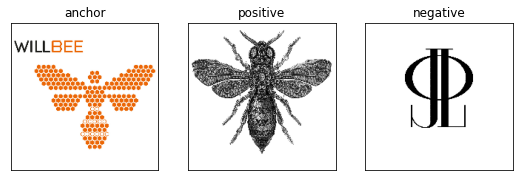

In [35]:
# initialize and load
dataset = ImageSearchDataset(batch_size=1, target_shape=target_shape)
dataset.load_dataset_from("Downloads/image_search/example/", positive_only=False)

# show example
dataset.show_sample()

## Create the Model
To seep up training and to improve the performance we use the pretrained weights, so we have some features already extract from a bigger dataset. This is a huge advantage, since we can use a wide range of features from the dataset imagenet which is we would need to train first, if we would create the network from scratch. In this case we will take the convolution layers from ResNet with pretrained weights and only adjust the last output layers to our needs but keep the rest as it is.

In [7]:
# Take the ResNet but exclude the top layers
base_cnn = resnet.ResNet50(
    weights = "imagenet", input_shape = target_shape + (3, ), include_top=False
)

# normalizes the vectors to have L2 norm 1
# helper function to normaize the output vectors of the network
def normalize(x):  
    return x / tf.math.sqrt(tf.reduce_sum(x * x, axis=-1, keepdims=True))


# create a model with by specifing the layers
# flatten the output from the convolutions
flatten = layers.Flatten()(base_cnn.output)

# create a first dense layer with BatchNormalization
dense1 = layers.Dense(512, activation="relu")(flatten)
dense1 = layers.BatchNormalization()(dense1)

# create a second dense layer with BatchNormalzation
dense2 = layers.Dense(256, activation="relu")(dense1)
dense2 = layers.BatchNormalization()(dense2)

# create output vectors and normalze the values once again
output = layers.Dense(256)(dense2)
output = layers.Lambda(normalize, name="Normalize")(output)

# create an Embedding model (this is the main model and will be called from wrappers later on)
embedding = Model(base_cnn.input, output, name="Embedding")


# ensure, that only the last layer of the imagenet convolutions is trained, otherwise keep the pre trained layers and
# set trainability of the layers to false
trainable = False
for layer in base_cnn.layers:
    if layer.name == "conv4_block1_out":
        trainable = True
    layer.trainable = trainable

Create a DistanceLayer which will calculate the distance between the ouput vectors to estimate how close two images are. You have several options here. You can go with a lot of different measures *(e.g. Cosine Simlarity, Manhatten Distance, ...)*, therefore I in encourage you to try also other measures and to test how the performance is influenced by it. For the final prediction one could use a $\tau$ (Tau) value as threshold for making results binary.

Example:
- X < $\tau$ -> 0
- X > $\tau$ -> 1

What exactly $\tau$ is depends on your usecase. It might be a good idea to get a choose $\tau$ empircal. Also can the threshold have implications on your results. The higher the value, the higher the restrictions for a positive match in the prediction.

In [8]:
class DistanceLayer(layers.Layer):
    """
    This layer is responsible for computing the distance between the anchor
    embedding and the positive embedding, and the anchor embedding and the negative embedding 
    """
    
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
    
    def call(self, anchor, positive, negative):
        """
        custom call function of the Layer parent class. takes three vectors and calculates
        the distances between the anchor|positive and anchor|negative
        :param anchor: output vector for the anchor image from the embedding network
        :param positive: output vector for the positive image form the embedding network
        :param negative: output vector for the negative image form the embedding network
        """
        
        ap_distance = tf.reduce_sum(tf.math.abs(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.math.abs(anchor - negative), -1)
        
        return (ap_distance, an_distance)
    
        
# create the input layers for the three images 
anchor_input = layers.Input(name="anchor", shape=target_shape + (3, )) # add tuple because we have three channel images
positive_input = layers.Input(name="positive", shape=target_shape + (3, ))
negative_input = layers.Input(name="negative", shape=target_shape + (3, ))


# define that the DistanceLayer (calcuation of the distances between anchor|positive and anchor|negative) takes the input images
# and applies the embedding model after appling the preprocessing routine from resnet
distance = DistanceLayer()(
    embedding(resnet.preprocess_input(anchor_input)),
    embedding(resnet.preprocess_input(positive_input)),
    embedding(resnet.preprocess_input(negative_input))
)

# define the final model with the input layers and output layer
siamese_network = Model(inputs=[anchor_input, positive_input, negative_input], outputs=distance)

In [9]:
class SiameseModel(Model):
    """
    The Siamese Network model with a custom training and testing loops.
    Computes the triplet loss using the three embeddings produced by the
    Siamese Network.

    The triplet loss is defined as:
       L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
    """  
    
    
    def __init__(self, siamese_network, margin=.5):
        super().__init__()
        self.siamese_network = siamese_network          # network previously defined
        self.margin = margin                            # margin to start with
        self.loss_tracker = metrics.Mean(name="loss")   # loss tracker - will track mean of loss (play around with it)
        
    def call(self, inputs):
        """
        takes the inputs and calls the siamese network we have defined
        """
        return self.siamese_network(inputs)
    
    def train_step(self, data):
        """
        executes a training step with the input data
        """
        
        # GradientTape is a context manager that records every operation that
        # you do inside. We are using it here to compute the loss so we can get
        # the gradients and apply them using the optimizer specified in `compile`
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)
        
        # Storing the gradients of the loss function with respect to the weights/parameters
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)
        
        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )
        
        # Let's udpate and return the training loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}
    
    def test_step(self, data):
        """
        computes loss on val set and returns the loss values
        """
        
        loss = self._compute_loss(data)
        
        # update and return the loss metric
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}
    
    def _compute_loss(self, data):
        """
        custom loss computation. takes the two output vectors from the network and
        applies the triplet loss function. The function will return the loss.
        """
        # The output of the network is a tuple containing the distances between
        # the anchor and the positive, & the anchor and the negative example
        ap_distance, an_distance = self.siamese_network(data)
        
        # TODO: To improve the loss calculation one could calculate the loss based on a batch matrix of vectors
        # TODO: multiplies them to get the positive samples on the diagonal
        # TODO: then calculate mean_negative_values and clostest_negative_value on axis=1
        # TODO: create a loss with thoese value each and add them. After that apply maximum
        
        # computing the Triplet Loss by substracting both distances and
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, .0)  # checkout some theory on that one -> ask maxim or maxims notes
        return loss
    
        
    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be called automatically
        return [self.loss_tracker]

## Train and evaluate the Model
In this section the model is trained and evaluated. A Adam optimizer is used for optimization. Keep in mind, that the *dataset* variable holds a class instance with the attributes *train_dataset* and *val_dataset* which will contain the tensorflow dataset. 

In [10]:
# init the siamese network with its custom training routine
siamese_model = SiameseModel(siamese_network)

# compile and train the model
siamese_model.compile(optimizer=optimizers.Adam(.0001))
history = siamese_model.fit(
    dataset.train_dataset,              # train dataset
    batch_size=1,                       # one batch since we only have 10 examples
    epochs=20,                          # gutfeeling - can be less
    validation_data=dataset.val_dataset # validation dataset
)

Epoch 1/20
9/9 [==============================] - 22s 1s/step - loss: 1.5064 - val_loss: 0.2500
Epoch 2/20
9/9 [==============================] - 7s 803ms/step - loss: 0.9985 - val_loss: 0.5388
Epoch 3/20
9/9 [==============================] - 7s 805ms/step - loss: 0.7608 - val_loss: 0.8289
Epoch 4/20
9/9 [==============================] - 7s 794ms/step - loss: 0.3422 - val_loss: 0.5000
Epoch 5/20
9/9 [==============================] - 7s 805ms/step - loss: 0.2470 - val_loss: 0.1807
Epoch 6/20
9/9 [==============================] - 7s 800ms/step - loss: 0.6267 - val_loss: 0.0419
Epoch 7/20
9/9 [==============================] - 7s 807ms/step - loss: 0.2183 - val_loss: 0.0000e+00
Epoch 8/20
9/9 [==============================] - 7s 811ms/step - loss: 0.4107 - val_loss: 0.0918
Epoch 9/20
9/9 [==============================] - 7s 805ms/step - loss: 0.5036 - val_loss: 0.3039
Epoch 10/20
9/9 [==============================] - 7s 795ms/step - loss: 0.3980 - val_loss: 0.8129
Epoch 11/20
9/9 [

Text(0, 0.5, 'loss')

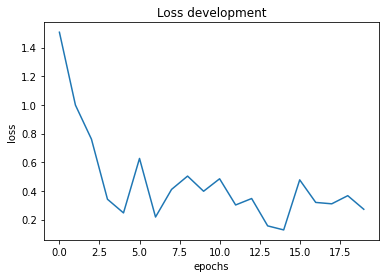

In [11]:
# Plot the loss over all epochs
plt.plot([i for i in range(len(history.history["loss"]))], history.history["loss"])
plt.title("Loss development")
plt.xlabel("epochs")
plt.ylabel("loss")

Positive similarity: 0.9995791
Negative similarity 0.9992425

Probabilities:
positive: 0.5000841617584229
negative: 0.49991586804389954

Nice match between the first two


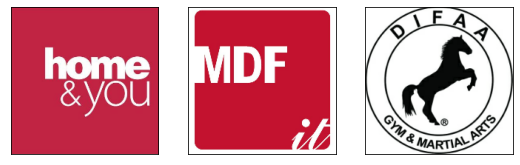

In [12]:
# get a sample form the validation dataset and show how it looks like
anchor, positive, negative = dataset.show_sample(dataset="val", return_sample=True)

# apply the network to get the ouput vectors on this example
anchor_embedding, positive_embedding, negative_embedding = (
    embedding(resnet.preprocess_input(anchor)),
    embedding(resnet.preprocess_input(positive)),
    embedding(resnet.preprocess_input(negative)),
)

# get a cosine similarity function
# TODO: create a CosineSimilarity layer instead of a DistanceLayer
cosine_similarity = metrics.CosineSimilarity()

# check out how similar the vectors are
positive_similarity = cosine_similarity(anchor_embedding, positive_embedding)
print("Positive similarity:", positive_similarity.numpy())

negative_similarity = cosine_similarity(anchor_embedding, negative_embedding)
print("Negative similarity", negative_similarity.numpy())


# create a probability distribution - not really needed but show how a distribution would look like
probs =tf.nn.softmax(np.array([positive_similarity, negative_similarity]))
print(f"\nProbabilities:\npositive: {probs[0]}\nnegative: {probs[1]}\n")

if positive_similarity > negative_similarity:
    print("Nice match between the first two")
else:
    print("You failed, that simple")

## Conclusion and Implications
As one can see, the result is good in terms of estimating which if the positive example is more similar than the negative compared to the anchor point. However, the difference seems marginal. The reason for this could lay in the extremly limited amount of 10 samples used for this model. A test with more training samples would be needed to prove if the networks performance increases. Also the network training is harmed by the fact that the low amount of samples sometime generates false negative examples due to the limited amount of variation. With more samples also this problem can be neglected.